# Class and size reduction of lower limb MRIs

### Author: José Verdú-Díaz
#### 20 June, 2021

This tool is part of poly2pix, freely available here: https://github.com/Jose-Verdu-Diaz/sa_poly2pixel
___

Load libraries

In [52]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

Load test image

In [53]:
file = '0037'
img_path = f'../../projects/RM1/img/0001-{file}.jpg'
mask_path = f'../../projects/RM1/masks/0001-{file}.bmp'

if os.path.isfile(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
else:
    print (f'The image {img_path} does not exist.')

if os.path.isfile(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
else:
    print (f'The image {mask_path} does not exist.')

# RGB images for figures
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
mask_rgb = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

Show the image, mask and histogram (log scale). 3 peaks can be seen, from left to right: the background, the dark grey muscle and the light grey fatty tissue.

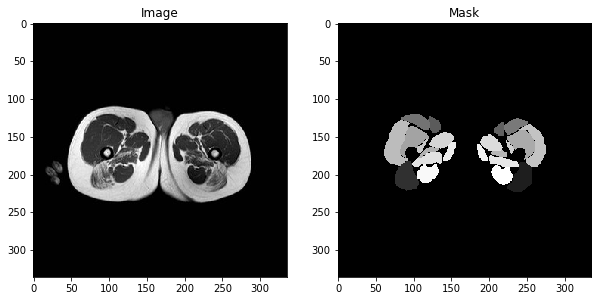

In [54]:
fig, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(img, cmap='gray', interpolation='none');
axs[0].set_title('Image');
axs[1].imshow(mask, cmap='gray', interpolation='none');
axs[1].set_title('Mask');

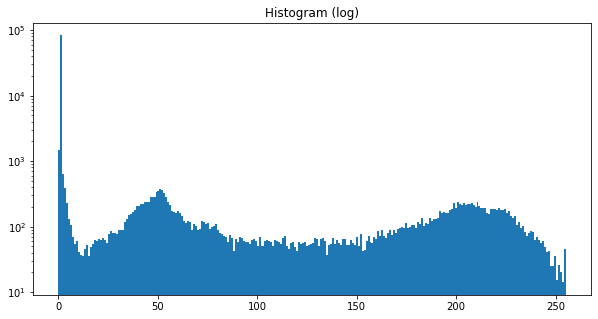

In [55]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(img.ravel(),256,[0,255]);
ax.set_title('Histogram (log)');
ax.set_yscale('log');

Apply a threshold between 20 and 100 (steps of 5). Search the optimum value by incrementing the threshold until two contours can be detected. Apply a morphologic transfrom to the thresholded image to clean any isolated white pixel.

4 found at max threshold


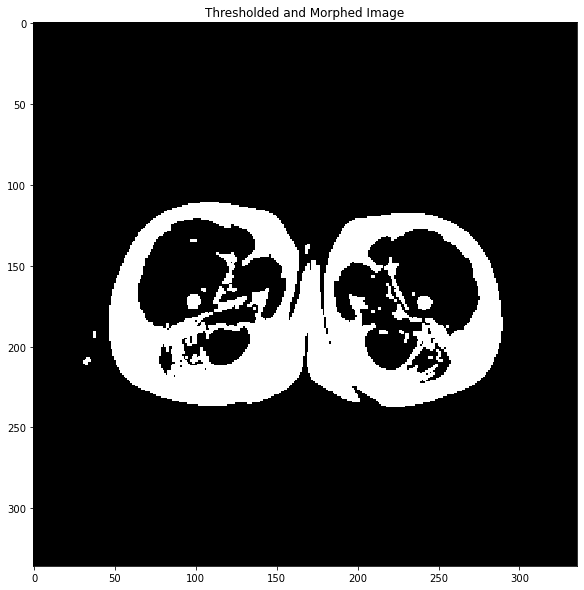

In [56]:
success = False
for th in np.arange(20, 101, 5).tolist():
    ret, thresh = cv2.threshold(img,th,255,cv2.THRESH_BINARY)

    # Remove white noise in mask
    kernel = np.ones((2,2),np.uint8)
    thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1) 
              
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours)==2:
        # Make sure that both contours are legs
        if cv2.contourArea(contours[0])*0.8 <= cv2.contourArea(contours[1]) <= cv2.contourArea(contours[0])*1.2:                  
            success = True
            print(f'Threshold: {th}')
            break
if not success:
    print(f'{len(contours)} found at max threshold')

fig, ax = plt.subplots(figsize=(10, 10));
ax.imshow(thresh, cmap='gray', interpolation='none');
ax.set_title('Thresholded and Morphed Image');

Obtain the centroids of each contour and identify the left and right legs.

Len of centroids is 4


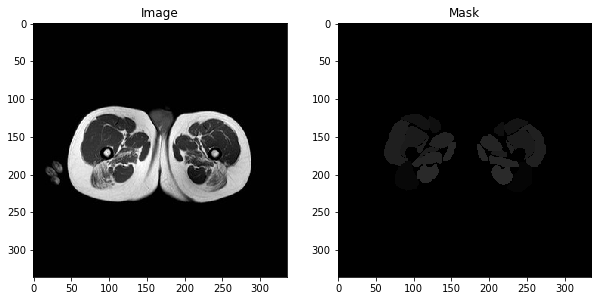

In [57]:
# Centroid of contours
centroids = []
for i,c in enumerate(contours):
    M = cv2.moments(c)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids.append((cX,cY))

if not len(centroids) == 2:
    print(f'Len of centroids is {len(centroids)}')
else:
    # Right: Azul
    # Left: Rojo
    if centroids[0][0] > centroids[1][0]:
        legs = {'left':contours[1], 'right':contours[0]}
        centroids = {'left':centroids[1],\
             'right':centroids[0]}

    elif centroids[0][0] < centroids[1][0]:
        legs = {'left':contours[0], 'right':contours[1]}
        centroids = {'left':centroids[0],\
             'right':centroids[1]}
    
    else: print('Error')

    cv2.drawContours(img_rgb, [legs['left']], -1,\
         (0, 0, 255), 2)
    cv2.drawContours(img_rgb, [legs['right']], -1,\
         (255, 0, 0), 2)
    cv2.circle(img_rgb, centroids['left'], 3,\
         (0, 0, 255), -1)
    cv2.circle(img_rgb, centroids['right'], 3,\
         (255, 0, 0), -1)

    cv2.drawContours(mask_rgb, [legs['left']], -1,\
         (0, 0, 255), 2)
    cv2.drawContours(mask_rgb, [legs['right']], -1,\
         (255, 0, 0), 2)
    cv2.circle(mask_rgb, centroids['left'], 3,\
         (0, 0, 255), -1)
    cv2.circle(mask_rgb, centroids['right'], 3,\
         (255, 0, 0), -1)
            


fig, axs = plt.subplots(1, 2, figsize=(10, 10));
axs[0].imshow(img_rgb, cmap='gray', interpolation='none');
axs[0].set_title('Image');
axs[1].imshow(mask_rgb, cmap='gray', interpolation='none');
axs[1].set_title('Mask');

Create a black background for the masks

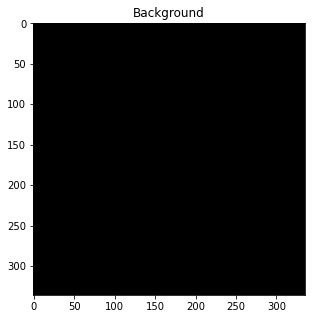

In [58]:
background = np.zeros(img.shape, np.uint8)

fig, ax = plt.subplots(figsize=(5, 5));
ax.imshow(background, cmap='gray', interpolation='none');
ax.set_title('Background');

Retrieve the leg masks from the contours and apply them on the original image and masks

In [59]:
leg_L = cv2.drawContours(background.copy(),\
     [legs['left']], -1, 255, -1)
leg_R = cv2.drawContours(background.copy(),\
     [legs['right']], -1, 255, -1)

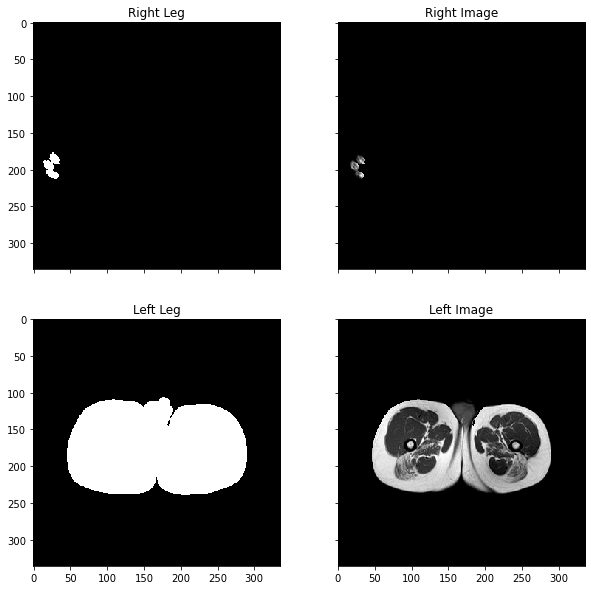

In [60]:
img_L = cv2.bitwise_and(img,img,mask = leg_L)
img_R = cv2.bitwise_and(img,img,mask = leg_R)

fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].imshow(leg_L, cmap='gray', interpolation='none');
axs[0,0].set_title('Right Leg');
axs[1,0].imshow(leg_R, cmap='gray', interpolation='none');
axs[1,0].set_title('Left Leg');
axs[0,1].imshow(img_L, cmap='gray', interpolation='none');
axs[0,1].set_title('Right Image');
axs[1,1].imshow(img_R, cmap='gray', interpolation='none');
axs[1,1].set_title('Left Image');

for ax in fig.get_axes(): ax.label_outer()

Repeat for the masks:

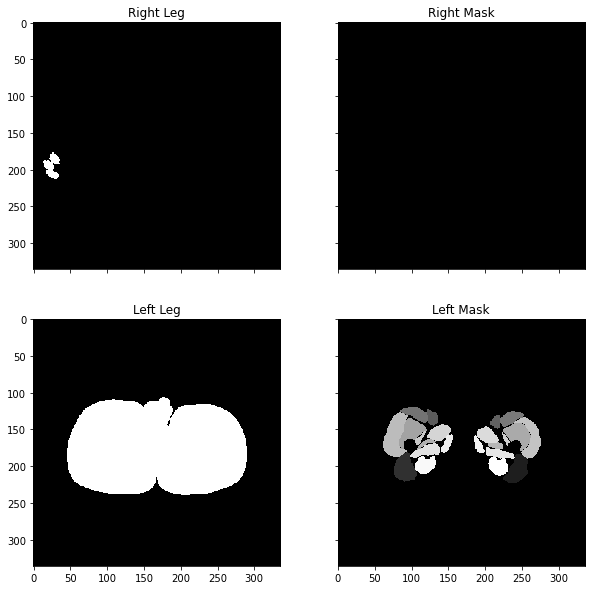

In [61]:
mask_L = cv2.bitwise_and(mask,mask,mask = leg_L)
mask_R = cv2.bitwise_and(mask,mask,mask = leg_R)

fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].imshow(leg_L, cmap='gray', interpolation='none');
axs[0,0].set_title('Right Leg');
axs[1,0].imshow(leg_R, cmap='gray', interpolation='none');
axs[1,0].set_title('Left Leg');
axs[0,1].imshow(mask_L, cmap='gray', interpolation='none');
axs[0,1].set_title('Right Mask');
axs[1,1].imshow(mask_R, cmap='gray', interpolation='none');
axs[1,1].set_title('Left Mask');

for ax in fig.get_axes(): ax.label_outer()

Find the bounding box of each leg, crop the images and masks to them and flip right leg. This way the number of muscle classes are halved and the size is reduced to almost a third part of the original size.

In [62]:
x_L,y_L,w_L,h_L = cv2.boundingRect(legs['left'])
x_R,y_R,w_R,h_R = cv2.boundingRect(legs['right'])

box_L = cv2.rectangle(cv2.cvtColor(img_L, cv2.COLOR_GRAY2BGR),\
    (x_L,y_L),(x_L+w_L,y_L+h_L),(0,255,0),2)
box_R = cv2.rectangle(cv2.cvtColor(img_R, cv2.COLOR_GRAY2BGR),\
    (x_R,y_R),(x_R+w_R,y_R+h_R),(0,255,0),2)

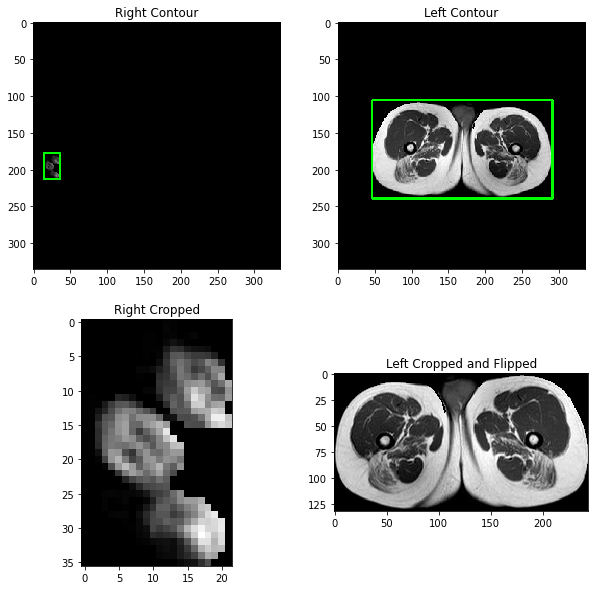

In [63]:
cropped_img_L = img_L[y_L:y_L+h_L, x_L:x_L+w_L]
cropped_img_R = cv2.flip(img_R[y_R:y_R+h_R, x_R:x_R+w_R], 1)

fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].imshow(box_L, cmap='gray', interpolation='none');
axs[0,0].set_title('Right Contour');
axs[0,1].imshow(box_R, cmap='gray', interpolation='none');
axs[0,1].set_title('Left Contour');
axs[1,0].imshow(cropped_img_L, cmap='gray', interpolation='none');
axs[1,0].set_title('Right Cropped');
axs[1,1].imshow(cropped_img_R, cmap='gray', interpolation='none');
axs[1,1].set_title('Left Cropped and Flipped');

Repeat for the masks:

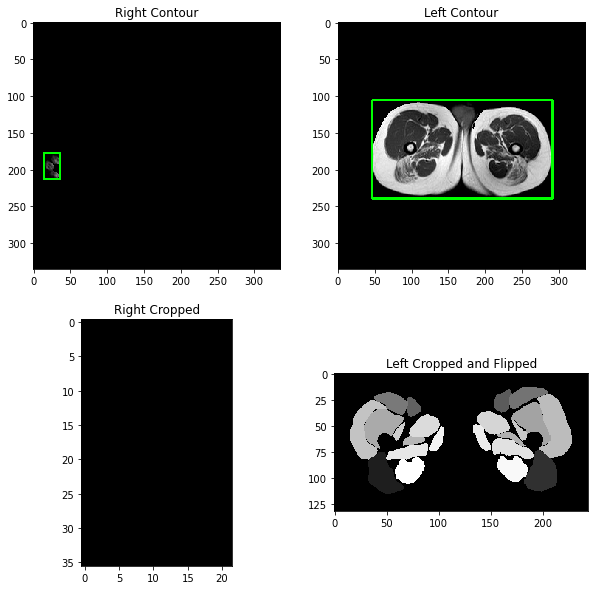

In [64]:
cropped_mask_L = mask_L[y_L:y_L+h_L, x_L:x_L+w_L]
cropped_mask_R = cv2.flip(mask_R[y_R:y_R+h_R, x_R:x_R+w_R], 1)

fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].imshow(box_L, cmap='gray', interpolation='none');
axs[0,0].set_title('Right Contour');
axs[0,1].imshow(box_R, cmap='gray', interpolation='none');
axs[0,1].set_title('Left Contour');
axs[1,0].imshow(cropped_mask_L, cmap='gray', interpolation='none');
axs[1,0].set_title('Right Cropped');
axs[1,1].imshow(cropped_mask_R, cmap='gray', interpolation='none');
axs[1,1].set_title('Left Cropped and Flipped');

All of this can be automated for a directory of images/masks with the following code (included in poly2pix):

In [65]:
## This code requires the following file structure:
#
#   ./
#   ┃
#   ┣━━ img/
#   ┣━━ masks/
#   ┗━━ reduction_test/
#       ┃
#       ┣━━ L/
#       ┃   ┃
#       ┃   ┣━━ img/
#       ┃   ┗━━ masks/
#       ┃
#       ┗━━ R/
#           ┃
#           ┣━━ img/
#           ┗━━ masks/
#
## Also, this code requires images to be in .jpg, and masks in .bmp.
## This can be changed on imwrite() on the bottom lines

prj_path = f'.'
output_path = f'{prj_path}/reduction_test'

if not os.path.exists(f'{output_path}/L/img'): 
    os.makedirs(f'{output_path}/L/img')
if not os.path.exists(f'{output_path}/L/masks'): 
    os.makedirs(f'{output_path}/L/masks')
if not os.path.exists(f'{output_path}/R/img'): 
    os.makedirs(f'{output_path}/R/img')
if not os.path.exists(f'{output_path}/R/masks'): 
    os.makedirs(f'{output_path}/R/masks')

for file in sorted(os.listdir(f'{prj_path}/img')):

    img = cv2.imread(f'{prj_path}/img/{file}',\
         cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(f'{prj_path}/masks/{file.strip(".jpg")}.bmp',\
         cv2.IMREAD_GRAYSCALE)

    centroids = []

    success = False
    for th in np.arange(20, 101, 5).tolist():
        ret, thresh = cv2.threshold(img,th,255,cv2.THRESH_BINARY)    

        # Remove white noise in mask
        kernel = np.ones((2,2),np.uint8)
        thresh = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel,\
             iterations = 1) 

        contours, hierarchy = cv2.findContours(thresh,\
             cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(contours)==2:                      
            success = True
            break

    if not success:
        print(f'ERROR ## {file} ## {len(contours)} contours')
        continue













    for i,c in enumerate(contours):
        M = cv2.moments(c)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX,cY))
    
    if len(centroids) > 2 or len(centroids) == 0:
        print(f'Len of centroids is {len(centroids)}')
    else:
        # Right: Azul
        # Left: Rojo
        if centroids[0][0] > centroids[1][0]:
            legs = {'left':contours[1], 'right':contours[0]}
            centroids = {'left':centroids[1], 'right':centroids[0]}

        elif centroids[0][0] < centroids[1][0]:
            legs = {'left':contours[0], 'right':contours[1]}
            centroids = {'left':centroids[0], 'right':centroids[1]}
                
        else: print('Error')

    background = np.zeros(img.shape, np.uint8)

    leg_L = cv2.drawContours(background.copy(),\
         [legs['left']], -1, 255, -1)
    leg_R = cv2.drawContours(background.copy(),\
         [legs['right']], -1, 255, -1)

    img_L = cv2.bitwise_and(img,img,mask = leg_L)
    img_R = cv2.bitwise_and(img,img,mask = leg_R)

    mask_L = cv2.bitwise_and(mask,mask,mask = leg_L)
    mask_R = cv2.bitwise_and(mask,mask,mask = leg_R)

    x_L,y_L,w_L,h_L = cv2.boundingRect(legs['left'])
    x_R,y_R,w_R,h_R = cv2.boundingRect(legs['right'])

    cropped_img_L = img_L[y_L:y_L+h_L, x_L:x_L+w_L]
    cropped_img_R = cv2.flip(img_R[y_R:y_R+h_R, x_R:x_R+w_R], 1)

    cropped_mask_L = mask_L[y_L:y_L+h_L, x_L:x_L+w_L]
    cropped_mask_R = cv2.flip(mask_R[y_R:y_R+h_R, x_R:x_R+w_R], 1)

    cv2.imwrite(f'{output_path}/L/img/{file.strip(".jpg")}_L.jpg',\
         cropped_img_L, [int(cv2.IMWRITE_JPEG_QUALITY), 100])
    cv2.imwrite(f'{output_path}/R/img/{file.strip(".jpg")}_R.jpg',\
         cropped_img_R, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

    cv2.imwrite(f'{output_path}/L/masks/{file.strip(".jpg")}_L.bmp',\
         cropped_mask_L)
    cv2.imwrite(f'{output_path}/R/masks/{file.strip(".jpg")}_R.bmp',\
         cropped_mask_R)

FileNotFoundError: [Errno 2] No such file or directory: './img'